## Learned Data Augmentation

Papers
* [RenderGAN: Generating Realistic Labeled Data](https://arxiv.org/abs/1611.01331)
* [Dataset Augmentation in Feature Space](https://arxiv.org/abs/1702.05538)
* [Learning to Compose Domain-Specific Transformations](https://arxiv.org/abs/1709.01643)
* [Data Augmentation Generative Adversarial Networks](https://arxiv.org/abs/1711.04340)
* [Data Augmentation in Emotion Classification Using GANs](https://arxiv.org/abs/1711.00648)
* [Neural Augmentation and Cycle GAN](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
* [Bayesian Data Augmentation Approach](https://arxiv.org/abs/1710.10564)
* [Larning To Model the Tail](https://papers.nips.cc/paper/7278-learning-to-model-the-tail)

Links
* https://blog.openai.com/requests-for-research-2/
* http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#4d4e495354

Approaches
1. Autoencoder: Encode --> Peturb/Interpolate --> Decode
2. Synthetic Dataset Generation with CGAN
3. Domain Adaption / Image-to-Image translation (CycleGAN)
4. Augmentation / Preprocessing Net + backprop classification loss

In [160]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys
p = os.path.join(os.path.dirname('__file__'), '..')
sys.path.append(p)
from common import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

In [458]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def get_cifar_loader(bs=64, trn_size=50000, tst_size=10000):
    trainTransform = torchvision.transforms.Compose([
        #torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor()
    ])
    testTransform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])

    trainset = torchvision.datasets.CIFAR10(
        root='../data', train=True, download=True, transform=trainTransform)
    trainset.train_data = trainset.train_data[:trn_size]
    trainset.train_labels = trainset.train_labels[:trn_size]
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=bs, shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(
        root='../data', train=False, download=True, transform=testTransform)
    testset.test_data = testset.test_data[:tst_size]
    testset.test_labels = testset.test_labels[:tst_size]
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=bs, shuffle=False, num_workers=2)

    return trainloader, testloader

def plot_tensor(img, fs=(10,10), title=""):
    npimg = img.numpy()
    plt.figure(figsize=fs)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()
    
def plot_metric(trn, tst, title):
    plt.plot(np.stack([trn, tst], 1));
    plt.title(title)
    plt.show()

In [310]:
batch_size = 64
trn_loader, tst_loader = get_cifar_loader(bs=batch_size, trn_size=5000, tst_size=2000)
inputs,targets = next(iter(train_loader))
len(trn_loader.dataset), len(tst_loader.dataset), inputs.size(), targets.size()

Files already downloaded and verified
Files already downloaded and verified


(5000, 2000, torch.Size([64, 3, 32, 32]), torch.Size([64]))

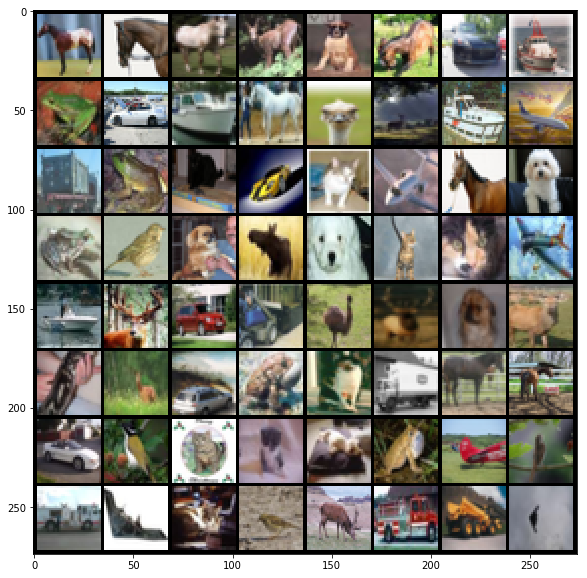

In [311]:
img = inputs[random.randint(0,64)]
plot_tensor(torchvision.utils.make_grid(inputs))

## CNN

In [300]:
def conv_bn_relu(in_chans, out_chans, kernel_size=3, stride=1, 
                 padding=1, bias=False):
    return [
        nn.Conv2d(in_chans, out_chans, kernel_size=kernel_size,
                  stride=stride, padding=padding, bias=bias),
        nn.BatchNorm2d(out_chans),
        nn.ReLU(inplace=True),
    ]

def linear_bn_relu_drop(in_chans, out_chans, dropout=0.5, bias=False):
    layers = [
        nn.Linear(in_chans, out_chans, bias=bias),
        nn.BatchNorm1d(out_chans),
        nn.ReLU(inplace=True)
    ]
    if dropout > 0:
        layers.append(nn.Dropout(dropout))
    return layers

class CNN(nn.Module):
    def __init__(self, in_shape, n_classes):
        super().__init__()
        c,w,h = in_shape
        pool_layers = 3
        fc_h = int(h / 2**pool_layers)
        fc_w = int(w / 2**pool_layers)
        self.features = nn.Sequential(
            *conv_bn_relu(c, 8, kernel_size=1, stride=1, padding=0),
            *conv_bn_relu(8, 32, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2), #size/2
            *conv_bn_relu(32, 32, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2), #size/2     
            *conv_bn_relu(32, 64, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2), #size/2
        )
        self.classifier = nn.Sequential(
            *linear_bn_relu_drop(64 * fc_h * fc_w, 256, dropout=0.25),
            nn.Linear(256, n_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [187]:
model = CNN(in_shape=(3,32,32), n_classes=10).cuda()

In [188]:
inputs,targets = next(iter(trn_loader))
output = model(Variable(inputs.cuda()))

## Train

In [183]:
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
trainer = training.QuickTrainer()
trainer.run(model, trn_loader, tst_loader, criterion, optimizer, epochs=20)

Epoch 1, TrnLoss: 2.163, TrnAcc: 0.345, TstLoss: 2.085, TstAcc: 0.419
Epoch 2, TrnLoss: 2.029, TrnAcc: 0.464, TstLoss: 1.996, TstAcc: 0.473
Epoch 3, TrnLoss: 1.960, TrnAcc: 0.519, TstLoss: 2.002, TstAcc: 0.467
Epoch 4, TrnLoss: 1.914, TrnAcc: 0.571, TstLoss: 1.953, TstAcc: 0.514
Epoch 5, TrnLoss: 1.883, TrnAcc: 0.595, TstLoss: 1.914, TstAcc: 0.550
Epoch 6, TrnLoss: 1.854, TrnAcc: 0.625, TstLoss: 1.912, TstAcc: 0.558
Epoch 7, TrnLoss: 1.826, TrnAcc: 0.656, TstLoss: 1.897, TstAcc: 0.567
Epoch 8, TrnLoss: 1.808, TrnAcc: 0.670, TstLoss: 1.893, TstAcc: 0.571
Epoch 9, TrnLoss: 1.779, TrnAcc: 0.702, TstLoss: 1.876, TstAcc: 0.588
Epoch 10, TrnLoss: 1.764, TrnAcc: 0.711, TstLoss: 1.900, TstAcc: 0.567
Epoch 11, TrnLoss: 1.753, TrnAcc: 0.727, TstLoss: 1.873, TstAcc: 0.588
Epoch 12, TrnLoss: 1.729, TrnAcc: 0.750, TstLoss: 1.877, TstAcc: 0.583
Epoch 13, TrnLoss: 1.722, TrnAcc: 0.758, TstLoss: 1.862, TstAcc: 0.599
Epoch 14, TrnLoss: 1.710, TrnAcc: 0.767, TstLoss: 1.846, TstAcc: 0.615
Epoch 15, TrnLo

In [184]:
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)
trainer.run(model, trn_loader, tst_loader, criterion, optimizer, epochs=10)

Epoch 1, TrnLoss: 1.631, TrnAcc: 0.842, TstLoss: 1.820, TstAcc: 0.640
Epoch 2, TrnLoss: 1.621, TrnAcc: 0.849, TstLoss: 1.821, TstAcc: 0.647
Epoch 3, TrnLoss: 1.606, TrnAcc: 0.869, TstLoss: 1.814, TstAcc: 0.649
Epoch 4, TrnLoss: 1.606, TrnAcc: 0.866, TstLoss: 1.815, TstAcc: 0.646
Epoch 5, TrnLoss: 1.597, TrnAcc: 0.874, TstLoss: 1.817, TstAcc: 0.642
Epoch 6, TrnLoss: 1.596, TrnAcc: 0.878, TstLoss: 1.821, TstAcc: 0.638
Epoch 7, TrnLoss: 1.589, TrnAcc: 0.884, TstLoss: 1.819, TstAcc: 0.642
Epoch 8, TrnLoss: 1.587, TrnAcc: 0.885, TstLoss: 1.813, TstAcc: 0.648
Epoch 9, TrnLoss: 1.584, TrnAcc: 0.889, TstLoss: 1.814, TstAcc: 0.650
Epoch 10, TrnLoss: 1.584, TrnAcc: 0.889, TstLoss: 1.831, TstAcc: 0.630


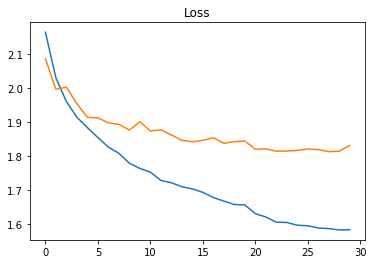

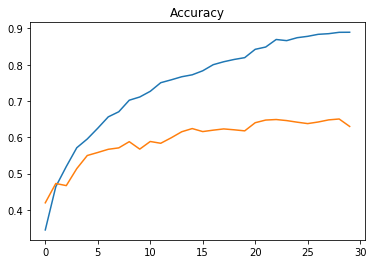

In [462]:
plot_metric(trainer.metrics['loss']['trn'], 
            trainer.metrics['loss']['tst'], 'Loss')
plot_metric(trainer.metrics['accuracy']['trn'], 
            trainer.metrics['accuracy']['tst'], 'Accuracy')

## Autoencoder

In [466]:
class CenterCrop(nn.Module):
    def __init__(self, height, width):
        super().__init__()
        self.height = height
        self.width = width
    
    def forward(self, img):
        bs, c, h, w = img.size()
        xy1 = (w - self.width) // 2
        xy2 = (h - self.height) // 2
        img = img[:, :, xy2:(xy2 + self.height), xy1:(xy1 + self.width)]
        return img

def train_autoencoder(model, dataloader, criterion, optim):
    model.train()
    total_loss = 0
    for img, _ in dataloader:
        inputs = Variable(img.cuda())

        output = model(inputs)
        loss = criterion(output, inputs)

        optim.zero_grad()
        loss.backward()
        optim.step()

        total_loss += loss.data[0]

    mean_loss = total_loss / len(dataloader)
    return mean_loss

def predict_autoencoder(model, img):    
    model.eval()
    if len(img.size()) == 3:
        c,h,w = img.size()
        img = img.view(1,c,h,w)
    img = Variable(img.cuda())
    out = model(img).data.cpu()
    return out

def predict_batch(model, loader):
    inputs, _ = next(iter(loader))
    out = predict_autoencoder(model, inputs)
    return out

def run(model, trn_loader, crit, optim, epochs):
    losses = []
    for epoch in range(epochs):
        loss = train_autoencoder(model, trn_loader, crit, optim)
        print('Epoch {:d} Loss: {:.4f}'.format(epoch+1, loss))
        if epoch % 10 == 0:
            samples = predict_batch(model, trn_loader)
            plot_tensor(torchvision.utils.make_grid(samples))
        losses.append(loss)
    return losses

### MLP Autoencoder

In [455]:
class MLPAE(nn.Module):
    def __init__(self, in_shape):
        super().__init__()
        c,h,w = in_shape
        self.encoder = nn.Sequential(
            nn.Linear(c*h*w, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(), 
            nn.Linear(64, 12), 
            nn.ReLU(), 
            nn.Linear(12, 3))
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(), 
            nn.Linear(128, c*h*w),
            nn.Sigmoid())

    def forward(self, x):
        bs,c,h,w = x.size()
        x = x.view(bs, -1)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(bs, c, h, w)
        return x

In [456]:
model = MLPAE(in_shape=(3,32,32)).cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

Epoch 1 Loss: 0.0333


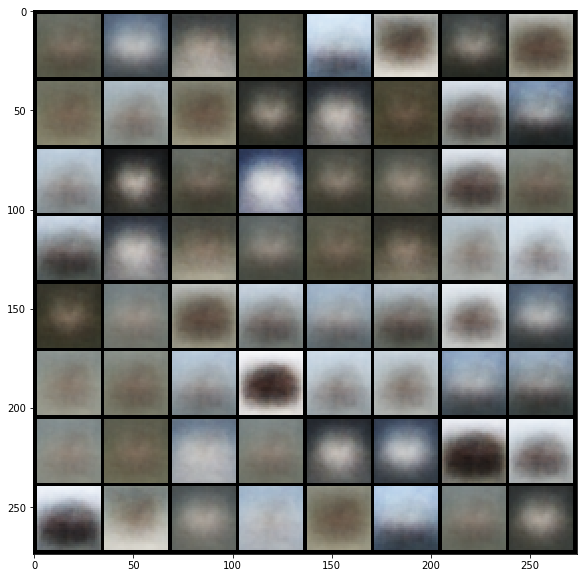

Epoch 2 Loss: 0.0332
Epoch 3 Loss: 0.0330
Epoch 4 Loss: 0.0331
Epoch 5 Loss: 0.0331
Epoch 6 Loss: 0.0332


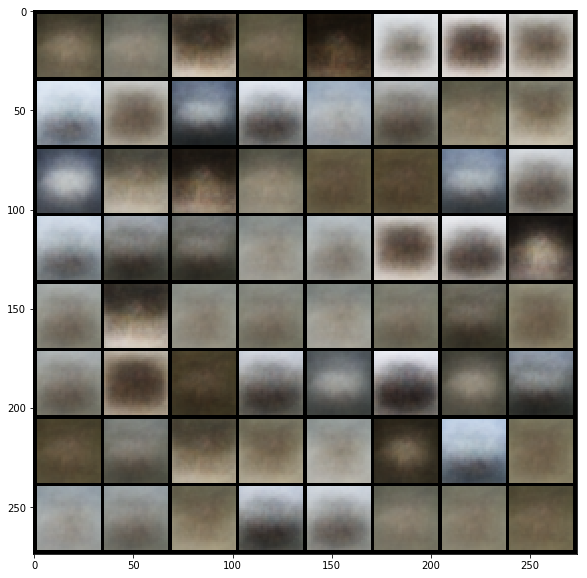

Epoch 7 Loss: 0.0332
Epoch 8 Loss: 0.0332
Epoch 9 Loss: 0.0330
Epoch 10 Loss: 0.0331
Epoch 11 Loss: 0.0331


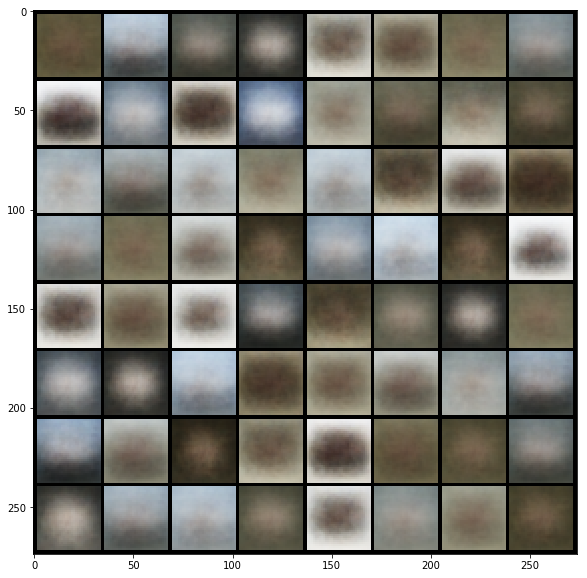

Epoch 12 Loss: 0.0331
Epoch 13 Loss: 0.0331
Epoch 14 Loss: 0.0331
Epoch 15 Loss: 0.0331
Epoch 16 Loss: 0.0330


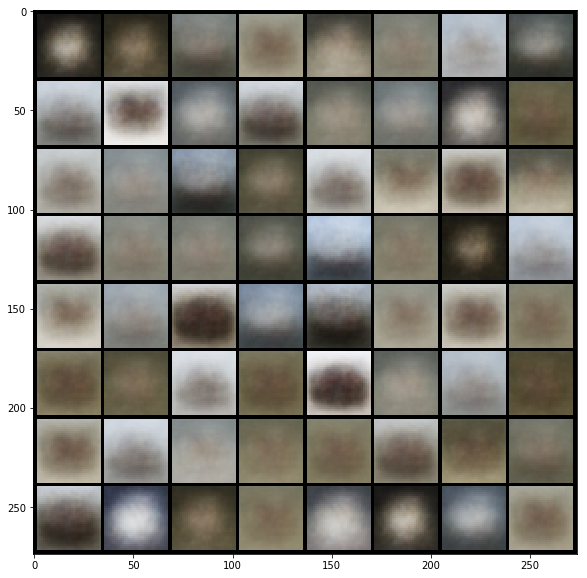

Epoch 17 Loss: 0.0330
Epoch 18 Loss: 0.0330
Epoch 19 Loss: 0.0329
Epoch 20 Loss: 0.0331


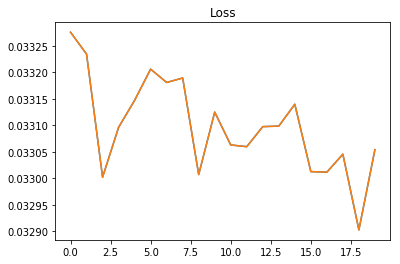

In [463]:
losses = run(model, trn_loader, criterion, optimizer, epochs=20)
plot_metric(losses, losses, 'Loss')

### Convolutional Autoencoder

* [Convolution Arithmetic](http://deeplearning.net/software/theano/tutorial/conv_arithmetic.html#transposed-convolution-arithmetic)

In [470]:
class ConvolutionalAE(nn.Module):
    def __init__(self, in_shape):
        super().__init__()
        c,h,w = in_shape
        self.encoder = nn.Sequential(
            nn.Conv2d(c, 16, kernel_size=3, stride=1, padding=1),  # b, 16, 32, 32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # b, 16, 16, 16
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),  # b, 8, 16, 16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # b, 8, 8, 8
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=0),  # 16, 17, 17
            nn.ReLU(),
            nn.ConvTranspose2d(16, c, kernel_size=3, stride=2, padding=1),  # 3, 33, 33
            CenterCrop(32, 32),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [471]:
model = ConvolutionalAE(in_shape=(3,32,32)).cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

Epoch 1 Loss: 0.0550


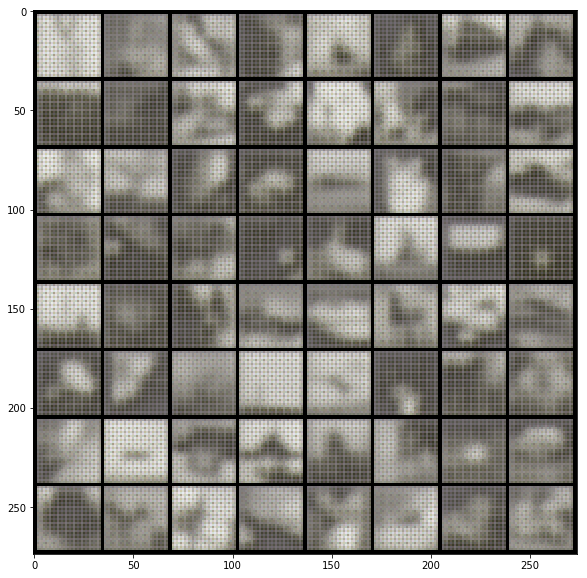

Epoch 2 Loss: 0.0214
Epoch 3 Loss: 0.0162
Epoch 4 Loss: 0.0144
Epoch 5 Loss: 0.0128
Epoch 6 Loss: 0.0109
Epoch 7 Loss: 0.0099
Epoch 8 Loss: 0.0094
Epoch 9 Loss: 0.0091
Epoch 10 Loss: 0.0090
Epoch 11 Loss: 0.0088


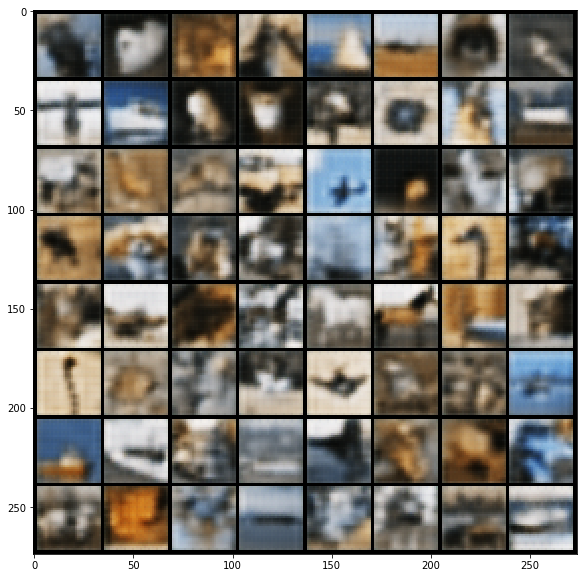

Epoch 12 Loss: 0.0086
Epoch 13 Loss: 0.0085
Epoch 14 Loss: 0.0083
Epoch 15 Loss: 0.0082
Epoch 16 Loss: 0.0081
Epoch 17 Loss: 0.0080
Epoch 18 Loss: 0.0079
Epoch 19 Loss: 0.0079
Epoch 20 Loss: 0.0078
Epoch 21 Loss: 0.0077


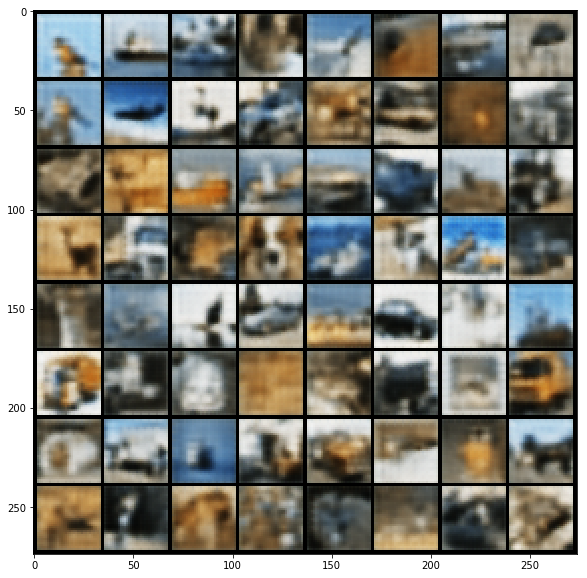

Epoch 22 Loss: 0.0076
Epoch 23 Loss: 0.0076
Epoch 24 Loss: 0.0075
Epoch 25 Loss: 0.0075
Epoch 26 Loss: 0.0074
Epoch 27 Loss: 0.0073
Epoch 28 Loss: 0.0072
Epoch 29 Loss: 0.0072
Epoch 30 Loss: 0.0072
Epoch 31 Loss: 0.0071


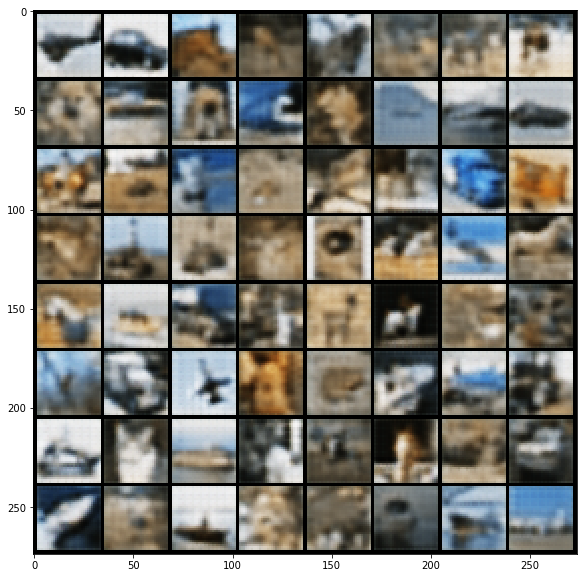

Epoch 32 Loss: 0.0070
Epoch 33 Loss: 0.0070
Epoch 34 Loss: 0.0070
Epoch 35 Loss: 0.0069
Epoch 36 Loss: 0.0069
Epoch 37 Loss: 0.0069
Epoch 38 Loss: 0.0068
Epoch 39 Loss: 0.0068
Epoch 40 Loss: 0.0067
Epoch 41 Loss: 0.0067


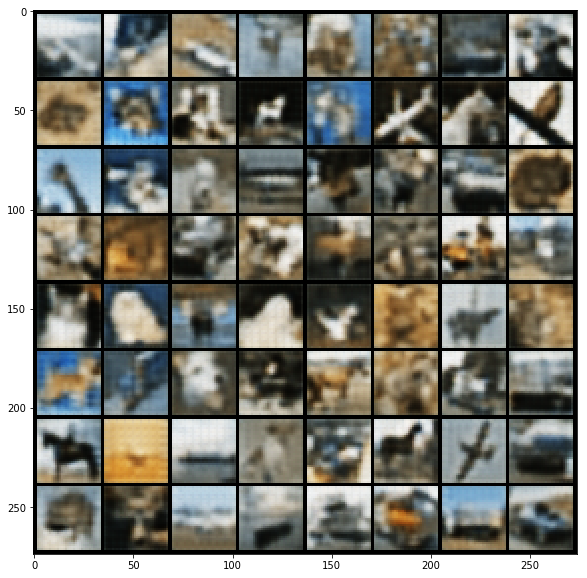

Epoch 42 Loss: 0.0066
Epoch 43 Loss: 0.0066
Epoch 44 Loss: 0.0066
Epoch 45 Loss: 0.0065
Epoch 46 Loss: 0.0065
Epoch 47 Loss: 0.0065
Epoch 48 Loss: 0.0064
Epoch 49 Loss: 0.0064
Epoch 50 Loss: 0.0064


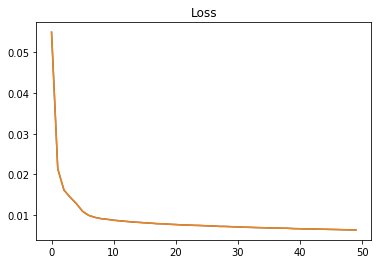

In [472]:
losses = run(model, trn_loader, criterion, optimizer, epochs=50)
plot_metric(losses, losses, 'Loss')

## VAE

* https://github.com/wiseodd/generative-models/blob/master/VAE/conditional_vae/cvae_pytorch.py

In [ ]:
def train_VAE(model, dataloader, criterion, optim):
    model.train()
    total_loss = 0
    for img, _ in dataloader:
        inputs = Variable(img.cuda())

        output = model(inputs)
        loss = criterion(output, inputs)

        optim.zero_grad()
        loss.backward()
        optim.step()

        total_loss += loss.data[0]

    mean_loss = total_loss / len(dataloader)
    return mean_loss